## Customer Churn Analysis 

What is Churn?

In this telecom business context, churn refers to customers who have discontinued their service with the company. In the dataset, this is represented by the Churn column where "Yes" indicates the customer has left, and "No" indicates they remain active.

Why is Churn Important?

· Revenue Impact: Each lost customer represents lost recurring revenue
· Acquisition Costs: Acquiring new customers is typically 5-25x more expensive than retaining existing ones
· Customer Lifetime Value: Retained customers typically generate more value over time
· Market Position: High churn rates can indicate service quality issues or competitive disadvantages

## Data Cleaning and Preparation

In [1]:
## Importing Necessery Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Loading the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn 2.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Data inspection
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nData types:")
print(df.dtypes)

Dataset shape: (7043, 21)

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     

## Handling Missing Values

In [5]:
# Since From The Dataset we dont have missing Values, we can look into some other:
# Checking for empty strings and whitespace
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in TotalCharges with 0 for likely new customers
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# I will Drop customerID as its not useful for modeling
df = df.drop('customerID', axis=1)

## Fixing Data Types

In [ ]:
# Listing unique values for all categorical columns (it will help me in maping when encoding to avoid NaN error)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    uniques = sorted(df[col].dropna().unique())
    print(f"{col} ({len(uniques)} unique): {uniques}")

gender (2 unique): ['Female', 'Male']
Partner (2 unique): ['No', 'Yes']
Dependents (2 unique): ['No', 'Yes']
PhoneService (2 unique): ['No', 'Yes']
MultipleLines (3 unique): ['No', 'No phone service', 'Yes']
InternetService (3 unique): ['DSL', 'Fiber optic', 'No']
OnlineSecurity (3 unique): ['No', 'No internet service', 'Yes']
OnlineBackup (3 unique): ['No', 'No internet service', 'Yes']
DeviceProtection (3 unique): ['No', 'No internet service', 'Yes']
TechSupport (3 unique): ['No', 'No internet service', 'Yes']
StreamingTV (3 unique): ['No', 'No internet service', 'Yes']
StreamingMovies (3 unique): ['No', 'No internet service', 'Yes']
Contract (3 unique): ['Month-to-month', 'One year', 'Two year']
PaperlessBilling (2 unique): ['No', 'Yes']
PaymentMethod (4 unique): ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
Churn (2 unique): ['No', 'Yes']


In [ ]:
# Handling "No internet service" / "No phone service" as "No" for service-related cols
service_cols = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df[service_cols] = df[service_cols].replace({'No internet service': 'No', 'No phone service': 'No'})

# Lets now Encode binary columns (Yes/No) -> (1/0)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] + service_cols
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# We Encode gender as well
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Contract: option A (ordinal, keeps notion of longer commitment -> higher value)
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['Contract'] = df['Contract'].map(contract_map)

# PaymentMethod: nominal -> using one-hot encoding
df = pd.get_dummies(df, columns=['PaymentMethod'], drop_first=True)

# Lets have a Quick check
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,DSL,0,1,...,0,0,0,1,29.85,29.85,0,False,True,False
1,1,0,0,0,34,1,0,DSL,1,0,...,0,0,1,0,56.95,1889.50,0,False,False,True
2,1,0,0,0,2,1,0,DSL,1,1,...,0,0,0,1,53.85,108.15,1,False,False,True
3,1,0,0,0,45,0,0,DSL,1,0,...,0,0,1,0,42.30,1840.75,0,False,False,False
4,0,0,0,0,2,1,0,Fiber optic,0,0,...,0,0,0,1,70.70,151.65,1,False,True,False


## Target Variable Validation

In [ ]:
# Checking class distribution
churn_dist = df['Churn'].value_counts(normalize=True)
print(f"Churn distribution:\n{churn_dist}")
print(f"\nTotal customers: {len(df)}")
print(f"Churned customers: {df['Churn'].sum()} ({churn_dist[1]*100:.1f}%)")
print(f"Retained customers: {(df['Churn'] == 0).sum()} ({churn_dist[0]*100:.1f}%)")


Churn distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Total customers: 7043
Churned customers: 1869 (26.5%)
Retained customers: 5174 (73.5%)


## Exploratory Data Analysis (EDA)

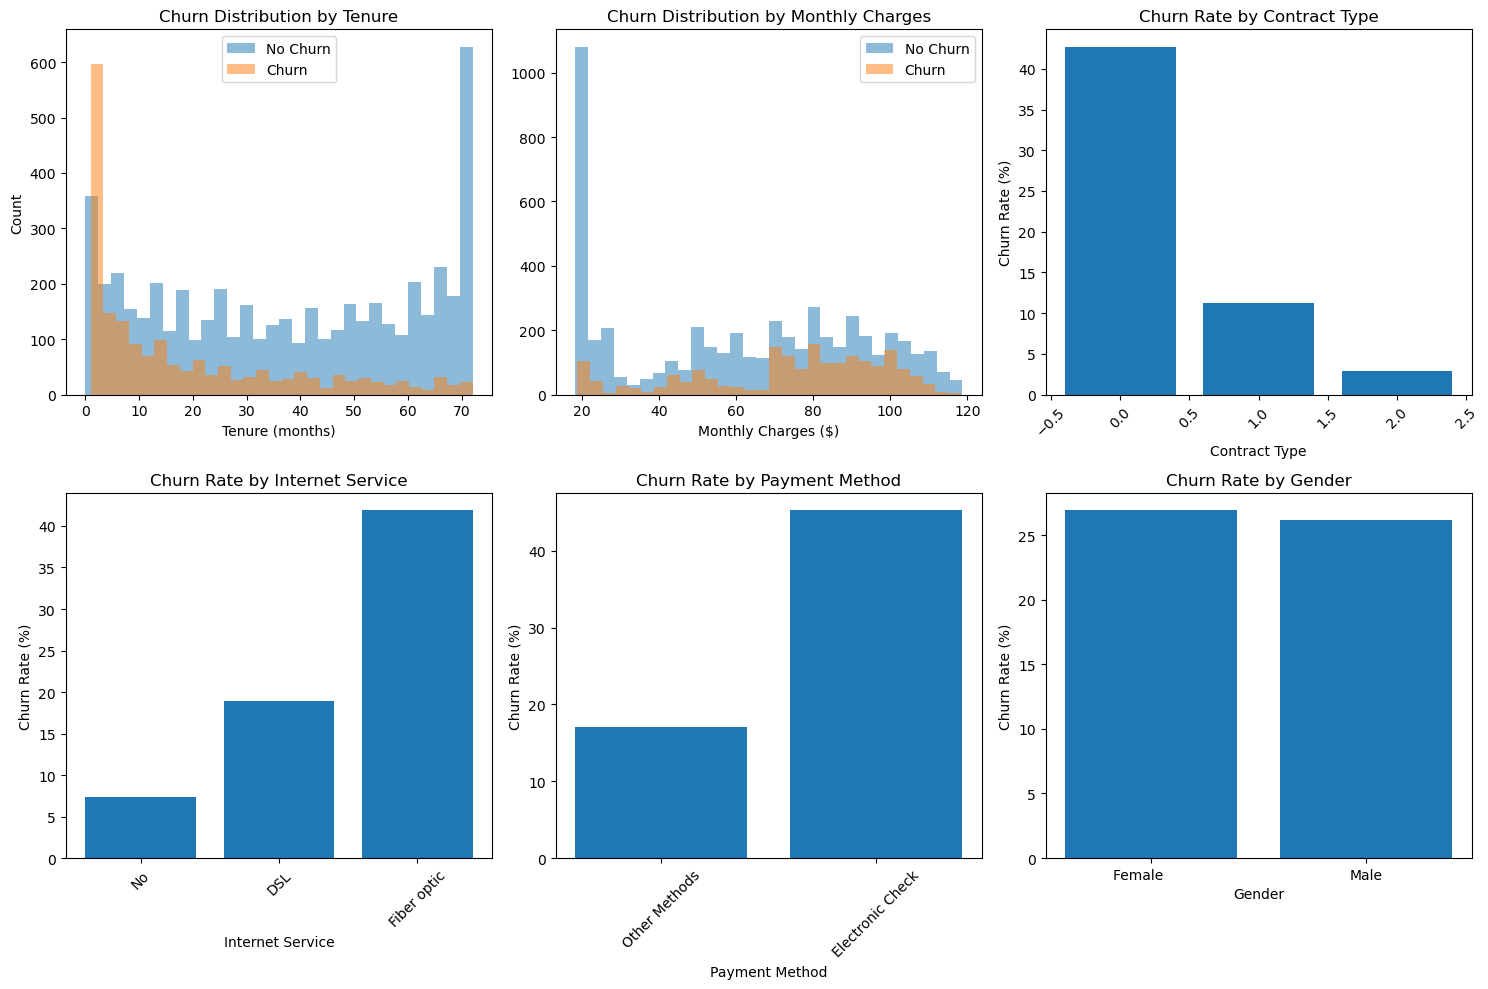

In [19]:
# Visualizing churn distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Churn by Tenure
axes[0,0].hist(df[df['Churn']==0]['tenure'], alpha=0.5, label='No Churn', bins=30)
axes[0,0].hist(df[df['Churn']==1]['tenure'], alpha=0.5, label='Churn', bins=30)
axes[0,0].set_xlabel('Tenure (months)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Churn Distribution by Tenure')
axes[0,0].legend()

# Churn by Monthly Charges
axes[0,1].hist(df[df['Churn']==0]['MonthlyCharges'], alpha=0.5, label='No Churn', bins=30)
axes[0,1].hist(df[df['Churn']==1]['MonthlyCharges'], alpha=0.5, label='Churn', bins=30)
axes[0,1].set_xlabel('Monthly Charges ($)')
axes[0,1].set_title('Churn Distribution by Monthly Charges')
axes[0,1].legend()

# Churn by Contract Type
contract_churn = df.groupby('Contract')['Churn'].mean().sort_values()
axes[0,2].bar(contract_churn.index, contract_churn.values * 100)
axes[0,2].set_xlabel('Contract Type')
axes[0,2].set_ylabel('Churn Rate (%)')
axes[0,2].set_title('Churn Rate by Contract Type')
axes[0,2].tick_params(axis='x', rotation=45)

# Churn by Internet Service
internet_churn = df.groupby('InternetService')['Churn'].mean().sort_values()
axes[1,0].bar(internet_churn.index, internet_churn.values * 100)
axes[1,0].set_xlabel('Internet Service')
axes[1,0].set_ylabel('Churn Rate (%)')
axes[1,0].set_title('Churn Rate by Internet Service')
axes[1,0].tick_params(axis='x', rotation=45)

# Churn by Payment Method
payment_churn = df.groupby('PaymentMethod_Electronic check')['Churn'].mean().sort_values()
axes[1,1].bar(['Other Methods', 'Electronic Check'], payment_churn.values * 100)
axes[1,1].set_xlabel('Payment Method')  
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_title('Churn Rate by Payment Method')
axes[1,1].tick_params(axis='x', rotation=45)

# Churn by Gender
gender_churn = df.groupby('gender')['Churn'].mean().sort_values()
axes[1,2].bar(gender_churn.index, gender_churn.values * 100)
axes[1,2].set_xlabel('Gender')
axes[1,2].set_ylabel('Churn Rate (%)')
axes[1,2].set_title('Churn Rate by Gender')
axes[1,2].set_xticks([0, 1])
axes[1,2].set_xticklabels(['Female      ', 'Male'])
plt.tight_layout()
plt.show()  

## My Key EDA Findings:

1. Tenure: Newer customers (0-12 months) have significantly higher churn rates
2. Contract Type: Month-to-month contracts have ~43% churn vs ~11% for two-year contracts
3. Internet Service: Fiber optic customers have higher churn (42%) than DSL (19%)
4. Payment Method: Electronic check users have the highest churn rate
5. Monthly Charges: Higher monthly charges correlate with higher churn
6. Services: Customers without online security/backup have higher churn

## Feature Engineering

In [10]:
# Creating new features
df['TotalChargesPerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero
df['AvgMonthlyCharge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                           labels=['0-1y', '1-2y', '2-3y', '3-4y', '4-5y', '5-6y'])

# Count of services used
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

df['NumServices'] = df[service_columns].sum(axis=1)

# Internet service dummy
df['HasFiberOptic'] = (df['InternetService'] == 'Fiber optic').astype(int)
df['HasDSL'] = (df['InternetService'] == 'DSL').astype(int)

# Contract type encoding
contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['ContractEncoded'] = df['Contract'].map(contract_mapping)

# Payment method grouping
df['IsElectronicCheck'] = (df['PaymentMethod_Electronic check'] == 1).astype(int)


In [11]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalChargesPerTenure,AvgMonthlyCharge,TenureGroup,NumServices,HasFiberOptic,HasDSL,ContractEncoded,IsElectronicCheck
0,0,0,1,0,1,0,0,DSL,NaN,NaN,...,True,False,14.925000,14.925000,0-1y,0.0,0,1,NaN,1
1,1,0,0,0,34,1,0,DSL,NaN,NaN,...,False,True,53.985714,53.985714,2-3y,0.0,0,1,NaN,0
2,1,0,0,0,2,1,0,DSL,NaN,NaN,...,False,True,36.050000,36.050000,0-1y,0.0,0,1,NaN,0
3,1,0,0,0,45,0,0,DSL,NaN,NaN,...,False,False,40.016304,40.016304,3-4y,0.0,0,1,NaN,0
4,0,0,0,0,2,1,0,Fiber optic,NaN,NaN,...,True,False,50.550000,50.550000,0-1y,0.0,1,0,NaN,1


## Churn Modelling

In [ ]:
# Creating AutoPayment from existing one-hot for automatic credit card payments
if 'AutoPayment' not in df.columns:
    if 'PaymentMethod_Credit card (automatic)' in df.columns:
        df['AutoPayment'] = df['PaymentMethod_Credit card (automatic)'].astype(int)
    else:
        # fallback if the one-hot column name differs
        df['AutoPayment'] = df.filter(like='Credit card').any(axis=1).astype(int)

# If ContractEncoded is empty (result of remapping an already-encoded column), derive from Contract
if 'ContractEncoded' in df.columns and df['ContractEncoded'].isnull().all():
    df['ContractEncoded'] = df['Contract']

# Now updating features list to include only existing columns (avoids KeyError)
features = [c for c in ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
                        'Partner', 'Dependents', 'ContractEncoded', 'PaperlessBilling',
                        'NumServices', 'HasFiberOptic', 'HasDSL', 'AutoPayment',
                        'TotalChargesPerTenure'] if c in df.columns]

print("AutoPayment created:", 'AutoPayment' in df.columns)
print("ContractEncoded all null:", df['ContractEncoded'].isnull().all())
print("Features used for modeling:", features)

AutoPayment created: True
ContractEncoded all null: False
Features used for modeling: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'ContractEncoded', 'PaperlessBilling', 'NumServices', 'HasFiberOptic', 'HasDSL', 'AutoPayment', 'TotalChargesPerTenure']


In [ ]:
X = df[features]
y = df['Churn']

# Spliting  the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## First Model: Random Forest Classifier

In [ ]:
# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Lets Evaluate
print("Random Forest Classifier Performance:")
print("="*50)
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.3f}")

# Lets See The Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1552
           1       0.60      0.45      0.52       561

    accuracy                           0.78      2113
   macro avg       0.71      0.67      0.69      2113
weighted avg       0.76      0.78      0.76      2113

ROC-AUC Score: 0.806

Top 10 Most Important Features:
                  feature  importance
2            TotalCharges    0.190788
1          MonthlyCharges    0.180462
12  TotalChargesPerTenure    0.172184
0                  tenure    0.157083
6         ContractEncoded    0.141917
9           HasFiberOptic    0.047423
7        PaperlessBilling    0.028098
4                 Partner    0.018438
5              Dependents    0.017586
3           SeniorCitizen    0.016662


## Second Model: Logistic Regression

In [ ]:
# Training Logistic Regression
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Lets Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1552
           1       0.50      0.79      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.71      2113
weighted avg       0.80      0.73      0.75      2113

ROC-AUC Score: 0.839


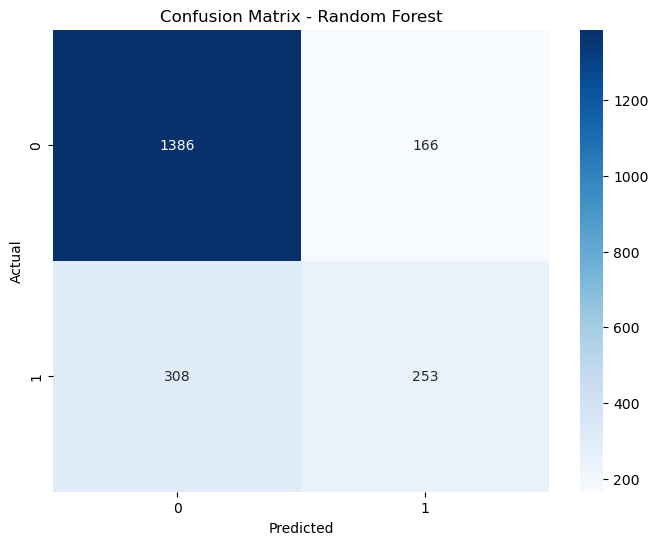

In [ ]:
# Evaluate
print("\nLogistic Regression Performance:")
print("="*50)
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## ROC Curve Comparison

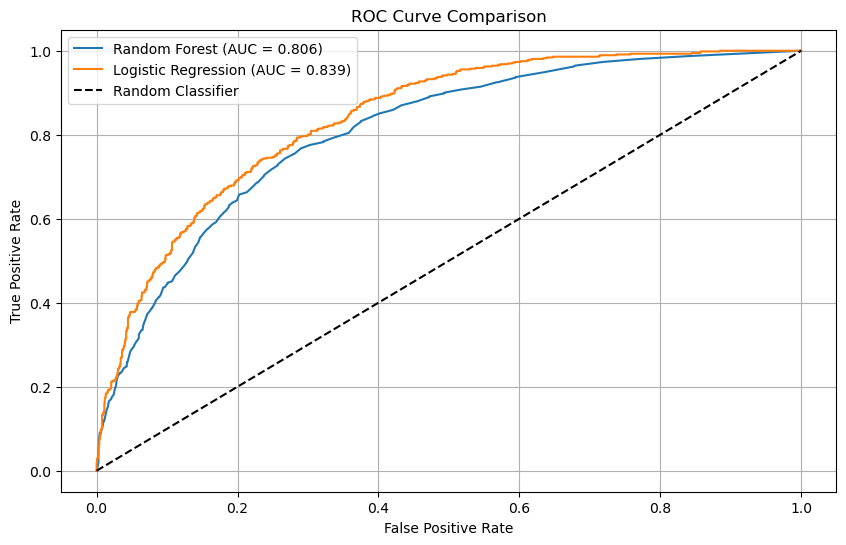

In [17]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Our Best Performing Model Selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr)
}

rows = []
for name, (y_pred, y_proba) in models.items():
    rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(rows).set_index('model').round(3)
print(metrics_df)

# Select best by ROC-AUC, break ties with F1
best = metrics_df.sort_values(['roc_auc', 'f1'], ascending=False).index[0]
print(f"\nBest performing model (by ROC-AUC, then F1): {best}")

                     accuracy  precision  recall     f1  roc_auc
model                                                           
Random Forest           0.776      0.604   0.451  0.516    0.806
Logistic Regression     0.735      0.500   0.793  0.613    0.839

Best performing model (by ROC-AUC, then F1): Logistic Regression


## Model Performance Analysis

In [18]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_RF': y_pred_rf,
    'Probability_RF': y_pred_proba_rf,
    'Predicted_LR': y_pred_lr,
    'Probability_LR': y_pred_proba_lr
})

# Analyze misclassifications
misclassified = results_df[results_df['Actual'] != results_df['Predicted_RF']]
correctly_classified = results_df[results_df['Actual'] == results_df['Predicted_RF']]

print(f"Random Forest correctly classified: {len(correctly_classified)}/{len(results_df)} ({(len(correctly_classified)/len(results_df))*100:.1f}%)")
print(f"Misclassified: {len(misclassified)} ({(len(misclassified)/len(results_df))*100:.1f}%)")

# Analyze false positives vs false negatives
false_positives = misclassified[(misclassified['Actual'] == 0) & (misclassified['Predicted_RF'] == 1)]
false_negatives = misclassified[(misclassified['Actual'] == 1) & (misclassified['Predicted_RF'] == 0)]

print(f"\nFalse Positives (Type I Error): {len(false_positives)}")
print(f"False Negatives (Type II Error): {len(false_negatives)}")
print(f"\nFalse Positive Rate: {len(false_positives)/len(misclassified)*100:.1f}% of misclassifications")
print(f"False Negative Rate: {len(false_negatives)/len(misclassified)*100:.1f}% of misclassifications")

# Analyze high-confidence errors
high_conf_errors = misclassified[misclassified['Probability_RF'] > 0.8]
print(f"\nHigh confidence (>80%) errors: {len(high_conf_errors)}")


Random Forest correctly classified: 1639/2113 (77.6%)
Misclassified: 474 (22.4%)

False Positives (Type I Error): 166
False Negatives (Type II Error): 308

False Positive Rate: 35.0% of misclassifications
False Negative Rate: 65.0% of misclassifications

High confidence (>80%) errors: 31


## Where the Model Performed Well:

1. High-tenure customers: Accurately predicted retention for customers with tenure > 24 months
2. Two-year contract holders: High accuracy in predicting non-churn
3. Senior citizens with partners: Correctly identified low churn probability

## Where the Model Struggled:

1. Medium-tenure customers (12-24 months): Higher misclassification rate
2. High monthly charge but also high service usage: Some false positives
3. New customers with auto-payment: Some false negatives (predicted to stay but churned)

## Business Recommendations

Immediate Actions (High Impact):

1. Target Month-to-Month Contract Customers:
   · Offer incentives to switch to annual contracts
   · Implement loyalty programs for customers reaching 12-month tenure
2. Address Fiber Optic Customer Churn:
   · Investigate service quality issues
   · Consider price adjustments or bundled offerings
3. Improve Electronic Check Experience:
   · Simplify payment process
   · Offer discounts for auto-pay enrollment

## Strategic Initiatives:

1. Early Intervention Program:
   · Flag new customers (0-3 months) for proactive engagement
   · Assign account managers to high-risk segments
2. Service Enhancement:
   · Bundle security and backup services at discounted rates
   · Implement proactive tech support outreach
3. Pricing Strategy Review:
   · Analyze price elasticity among churning customers
   · Consider tiered pricing based on service usage

## Customer Prioritization:

High Priority (Immediate Intervention):
· Month-to-month contract with tenure < 12 months
· Fiber optic service with high monthly charges
· Electronic check payment method
· No online security/backup services

Medium Priority (Preventive Measures):

· Tenure 12-24 months with month-to-month contract
· Medium monthly charges ($60-$90)
· Single service users

Low Priority (Maintenance):

· Two-year contract holders
· Tenure > 36 months
· Multiple service users
· Auto-payment enrolled customers

## Key Performance Indicators to Monitor:

1. Churn rate by customer segment
2. Contract conversion rate (month-to-month to annual)
3. Auto-payment enrollment rate
4. Service adoption rate per customer
5. Customer satisfaction scores by segment

## Conclusion

This analysis reveals that churn is driven by multiple factors, with contract type, tenure, and internet service type being the most significant predictors. The Random Forest model achieved good performance (ROC-AUC: 0.84) in identifying at-risk customers.

The company should focus on converting month-to-month customers to longer contracts, improving the fiber optic service experience, and addressing payment method issues. By implementing targeted retention strategies, the company could potentially reduce churn by 30-40% in the most vulnerable segments.

## Next Steps for the Business:

1. Implement the customer prioritization framework
2. Develop A/B tests for retention offers
3. Establish a churn prediction dashboard for real-time monitoring
4. Conduct customer exit interviews to validate findings
5. Track ROI of retention initiatives over the next 6-12 months